# Fitting DEBtox2019 to data

In [1]:
%load_ext autoreload
%autoreload 2

In [66]:
from debtox2019 import *
import seaborn as sns
sns.set_context('notebook')
sns.set_style('darkgrid')

## Default sim

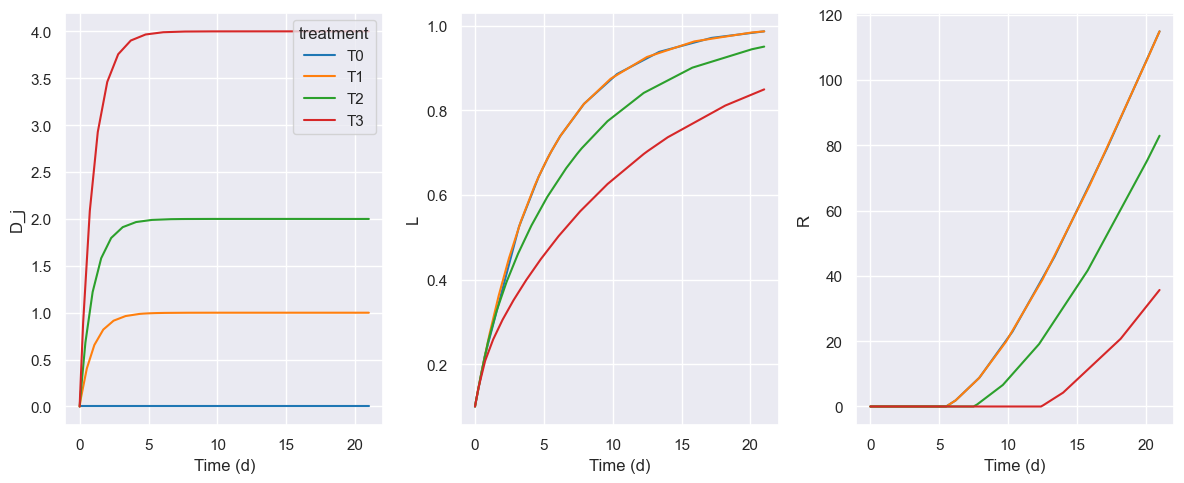

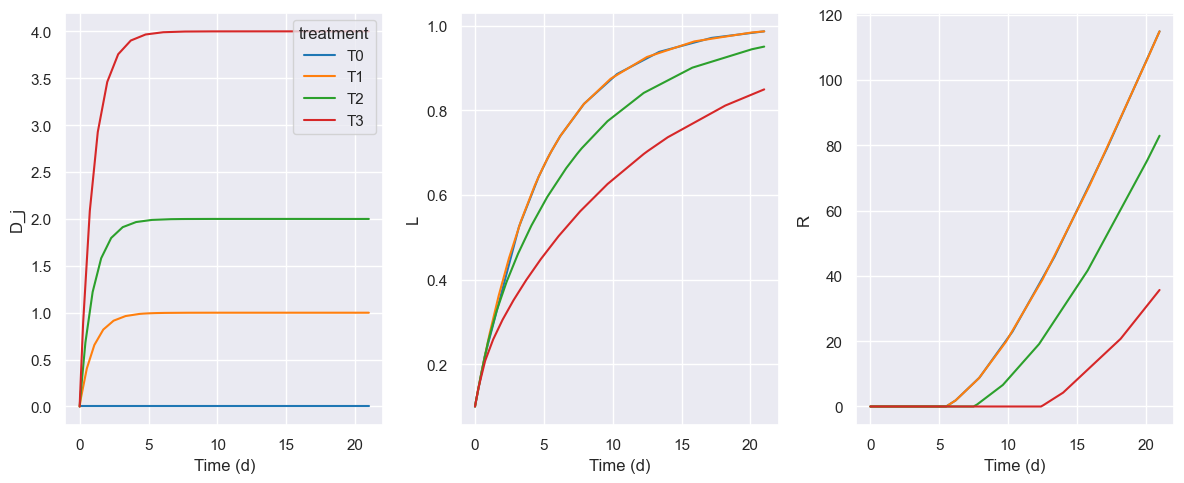

In [67]:
p = defaultparams_debtox2019.copy()

p['pmoa'] = 'G'

sim = simulate_debtox(p)
fig, ax = plot_debtox2019(sim, group = 'treatment')

sim = simulate_debtox(p)
fig, ax = plot_debtox2019(sim, group = 'treatment')

## Model fit class

In [ ]:
# ModelFittingAssistant.py
# Defines the ModelFit class

from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import pyabc
import tempfile
import os


def SSQ(a, b): 
    """
    Sum of squared errors. Example for a loss function.
    """
    return np.sum(np.power(a - b), 2)

class ModelFit:
    """
    A class to guide modellers through the model fitting process. 

    Use `fit = ModelFit()` to initialize an empty model fitting object. 
    Use `fit.guide()` to get an update on which components are still missing.

    After all components have been defined, use either `fit.Bayesian_inference()` 
    to perform Bayesian inference of parameters using SMC-ABC from the pyabc package, 
    or `fit.optimization()` to perform optimization, which internally calls `scipy.optimize.minimize()`.
    """

    def __init__(self):

        self.data: dict = None
        self.simulator: function = None
        self.loss: function = None
        self.prior = None
        self.intguess: dict = None
        self.default_params: dict = None
        
        self.optimization_result = None
        self.abc_history = None
        self.accepted = None

    def plot_priors(self, **kwargs):
        """
        Plot pdfs of the prior distributions. Kwargs are passed down to the plot command.
        """
        
        nrows = int(np.ceil(len(self.prior.keys())/3))
        ncols = np.minimum(3, len(self.prior.keys()))

        fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12,6*nrows))
        ax = np.ravel(ax)

        for i,p in enumerate(self.prior.keys()):

            xrange = np.geomspace(self.prior[p].ppf(0.0001),self.prior[p].ppf(0.9999), 10000)
            ax[i].plot(xrange, self.prior[p].pdf(xrange), **kwargs)
            ax[i].set(xlabel = p)

        ax[0].set(ylabel = "Prior density")
        sns.despine()

        return fig, ax
    
    def prior_sample(self):
        """
        Draw a sample from the priors.
        """
        samples = [self.prior[p].rvs() for p in self.prior.keys()]
        return dict(zip(self.prior.keys(), samples))
    

    def define_lognorm_prior(self, p_int = None, sigma = 1):
        """
        Define log-normal priors with median equal to initial guess and constant sigma (SD of log values).
        """

        if not p_int:
            p_int = self.intguess

        self.prior = pyabc.Distribution()

        for (par,val) in zip(p_int.keys(), p_int.values()):
            self.prior[par] = pyabc.RV("lognorm", sigma, 0, val)
    
    def prior_predictive_check(self, n = 100):
        """
        Evaluates n prior samples. 
        """
        
        self.prior_predictions = []

        for i in range(n): 
            sim = self.simulator(self.prior_sample())
            self.prior_predictions.append(sim)

    def run_bayesian_inference(
            self, 
            popsize = 1000,
            max_total_nr_simulations = 10_000, 
            max_nr_populations = 10,
            temp_database = "data.db"
            ):
        
        """
        Apply Bayesian inference, using Sequential Monte Carlo Approximate Bayesian Computation (SMC-ABC) 
        from the `pyABC` package.
        """
        
        # pyabc expects the data in dict format 
        # if the data is not already given in dict format, 
        # we define a dict with a single entry, 
        # and define a wrapper around the loss function 
        if type(self.data)!=dict: 
            data_smc = {'data' : self.data}

            def loss_SMC(predicted, data):
                return self.loss(predicted, data["data"])
            
        # if the data is already given in dict format, we assume that we can use it as is, 
        # same for the loss function
        else:
            data_smc = self.data
            loss_SMC = self.loss

        # setting things up
        abc = pyabc.ABCSMC( 
            self.simulator, 
            self.prior, 
            loss_SMC, 
            population_size=popsize
            )
         
        db_path = os.path.join(tempfile.gettempdir(), temp_database) # pyABC stores some information in a temporary file, this is set up here
        abc.new("sqlite:///" + db_path, data_smc) # the data is defined as a database entry
        history = abc.run( # running the SMC-ABC
            max_total_nr_simulations = max_total_nr_simulations, # we set a limit on the maximum number of simulations to run
            max_nr_populations = max_nr_populations # and a limit on the maximum number of populations, i.e. successive updates of the probability distributions
            )
        
        # constructing a data frame with accepted parameter values and weights
        accepted, weights = history.get_distribution()
        accepted = accepted.reset_index().assign(weight = weights)

        print("Conducted Bayesian inference using SMC-ABC. Results are in `abc_history` and `accepted`")

        self.abc_history = history
        self.accepted = accepted

    def posterior_sample(self):
        """ 
        Draw a posterior sample from accepted particles.
        """

        sample_ar = self.accepted.sample(weights = 'weight')[list(self.prior.keys())].iloc[0]
        return dict(zip(self.prior.keys(), sample_ar))


    def retrodict(self, n = 100):
        """ 
        Generate retrodictions based on `n` posterior samples.
        """

        self.retrodictions = []

        for i in range(n): 
            sim = self.simulator(self.posterior_sample())
            self.retrodictions.append(sim)

    def define_objective_function(self, for_use_with = 'scipy'):
        
        if for_use_with == 'scipy':
            def objective_function(parvals):
                """
                Objective function for the model contained in a ModelFit object
                """
                
                pfit = self.intguess.copy()
                pfit.update(dict(zip(self.intguess.keys(), parvals)))
                
                # calling the simulator function

                prediction = self.simulator(pfit)

                # calling the loss function
                
                return self.loss(prediction, self.data)
            
            return objective_function
        
        if for_use_with == 'lmfit':
            def objective_function(parvals):
                """
                Objective function for the model contained in a ModelFit object
                """

                parslist = [param.value for param in list(parvals.values())]
                
                pfit = self.intguess.copy()
                pfit.update(dict(zip(self.intguess.keys(), parslist)))
    
                # calling the simulator function

                prediction = self.simulator(pfit)

                # calling the loss function
                
                return self.loss(prediction, self.data)
            
            return objective_function


    def run_optimization(
            self,
            method = 'Nelder-Mead',
            **kwargs
        ): 
        """ 
        Apply an optimization algorithm using `scipy.optimize.minimize`.
        """

        objective_function = self.define_objective_function()

 
        opt = minimize(
            objective_function, # objective function 
            list(self.intguess.values()), # initial guesses
            method = method, # optimization method to use
            **kwargs
            )
               
        print(f"Fitted model using {method} method. Results stored in `optimization_result`")

        self.optimization_result = opt
        self.p_opt = dict(zip(self.intguess.keys(), opt.x))


    def __repr__(self):
        return f"ModelFit(data={self.data}, simulator={self.simulator}, prior={self.prior}, intguess={self.intguess})"


## Loading data

In [83]:
from modelfitting import *

In [89]:
fit = ModelFit()

fit.data = load_data({
    'growth': ('../azoxy_static_growth_tidy.csv', {'skiprows' : 4}),
    'repro' : ('../azoxy_static_repro_tidy.csv', {'skiprows' : 4})
    })

fit.data

{'growth':      index    C_W  t_day  length_mm
 0        0    0.0      0       0.89
 1        1    0.0      2       1.26
 2        2    0.0      4       1.63
 3        3    0.0      7       3.24
 4        4    0.0      9       2.76
 ..     ...    ...    ...        ...
 895    895  200.0     11       2.97
 896    896  200.0     14       3.28
 897    897  200.0     16       3.04
 898    898  200.0     18       3.75
 899    899  200.0     21       3.87
 
 [900 rows x 4 columns],
 'repro':     t_day  cum_repro  C_W
 0       0        0.0    0
 1       0        0.0   10
 2       0        0.0   40
 3       0        0.0  100
 4       0        0.0  200
 ..    ...        ...  ...
 57     11        0.0  250
 58     14        0.0  250
 59     16        0.0  250
 60     18        0.0  250
 61     21        0.7  250
 
 [62 rows x 3 columns]}